### Import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
df = pd.read_csv(r'D:\DataSets\Google Stock Price Prediction\preprocessed_CAC40.csv', parse_dates=['Date'])
print("shape of dataset is ",df.shape)
df.head()

shape of dataset is  (97648, 8)


,Unnamed: 0,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
0,0,Accor,2020-04-03,22.99,23.40,23.40,22.99,67
1,1,Accor,2020-04-02,23.91,22.99,23.91,22.99,250
2,2,Accor,2020-04-01,24.10,23.83,24.10,23.83,37
3,3,Accor,2020-03-31,25.04,25.00,25.24,24.99,336
4,4,Accor,2020-03-30,26.50,25.02,26.50,24.99,415


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97648 entries, 0 to 97647
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     97648 non-null  int64         
 1   Name           97648 non-null  object        
 2   Date           97648 non-null  datetime64[ns]
 3   Open           97418 non-null  float64       
 4   Closing_Price  97646 non-null  float64       
 5   Daily_High     97444 non-null  float64       
 6   Daily_Low      97444 non-null  float64       
 7   Volume         77195 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 6.0+ MB


In [4]:
df.drop(['Unnamed: 0'],axis = 1,inplace = True)
df.columns

Index(['Name', 'Date', 'Open', 'Closing_Price', 'Daily_High', 'Daily_Low',
       'Volume'],
      dtype='object')

In [5]:
def load_data(company, start, end):
    dataframe = df.copy()
    dataframe = dataframe.loc[dataframe.Name == company, :]
    dataframe = dataframe.loc[(dataframe['Date'] > start) & (dataframe['Date'] < end), :]
    dataframe = dataframe.rename(columns = {'Closing_Price': 'Close'})
    return dataframe

In [6]:
COMPANY = 'Accor'
START_DATE = dt.datetime(2015,1,1)
END_DATE = dt.datetime(2020,1,1)
START_DATE_TEST = END_DATE
START_DATE_TEST

datetime.datetime(2020, 1, 1, 0, 0)

In [7]:
data = load_data(company = COMPANY,start = START_DATE,end = END_DATE)

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [9]:
# how many days do i want to base my predictions on ?
prediction_days = 60
x_train = []
y_train = []
for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [10]:
def LSTM_model():
    model = Sequential()
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    return model

In [11]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam',loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [12]:
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5',verbose = 2, save_best_only = True)
model.fit(x_train,y_train,epochs=20,batch_size = 32,callbacks = [checkpointer])

Epoch 1/20
38/38 [==============================] - 8s 52ms/step - loss: 0.0436
Epoch 2/20
38/38 [==============================] - 2s 51ms/step - loss: 0.0122
Epoch 3/20
38/38 [==============================] - 2s 51ms/step - loss: 0.0097
Epoch 4/20
38/38 [==============================] - 2s 57ms/step - loss: 0.0090
Epoch 5/20
38/38 [==============================] - 3s 74ms/step - loss: 0.0092
Epoch 6/20
38/38 [==============================] - 3s 71ms/step - loss: 0.0085
Epoch 7/20
38/38 [==============================] - 3s 73ms/step - loss: 0.0081
Epoch 8/20
38/38 [==============================] - 3s 73ms/step - loss: 0.0077
Epoch 9/20
38/38 [==============================] - 3s 73ms/step - loss: 0.0073
Epoch 10/20
38/38 [==============================] - 3s 72ms/step - loss: 0.0074
Epoch 11/20
38/38 [==============================] - 3s 68ms/step - loss: 0.0077
Epoch 12/20
38/38 [==============================] - 3s 83ms/step - loss: 0.0070
Epoch 13/20
38/38 [==================

In [13]:
# test model accuracy on existing data
test_data = load_data(company = COMPANY, start = START_DATE_TEST,end = dt.datetime.now())
actual_prices = test_data['Close'].values
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [14]:
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

3/3 [==============================] - 1s 16ms/step


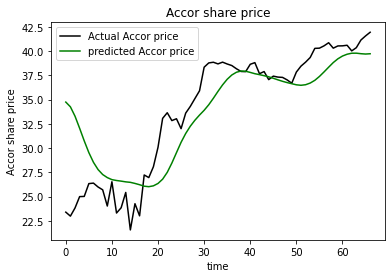

In [15]:
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")
plt.plot(predicted_prices, color= 'green', label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

In [16]:
# predicting next day
real_data = [model_inputs[len(model_inputs)+1 - prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [17]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"prediction: {prediction}")

1/1 [==============================] - 1s 1s/step
prediction: [[39.829014]]
